<a href="https://colab.research.google.com/github/adcaceres69/Proyecto-DENGUE/blob/main/DESAFIO_AlgoritmoML_MVP_CACERES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Se podría predecir la cantidad total de casos en una epidemia de Dengue?

In [124]:
# herramientas para el análisis de datos
import pandas as pd
import numpy as np

# librerías gráficas
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn.metrics import mean_absolute_error


## Cargando Datos

In [3]:
# cargar datos
df_features = pd.read_csv('/dengue_features_train.csv')
df_label = pd.read_csv('/dengue_labels_train.csv')

In [4]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [5]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [6]:
# Cantidad de filas y columnas en los dataset
print('El dataset "df_features" tiene ' + str(df_features.shape[0]) + ' filas, y ' + str(df_features.shape[1]) + ' columnas.')
print('El dataset "df_label" tiene ' + str(df_label.shape[0]) + ' filas, y ' + str(df_label.shape[1]) + ' columnas.')

El dataset "df_features" tiene 1456 filas, y 24 columnas.
El dataset "df_label" tiene 1456 filas, y 4 columnas.


In [7]:
# Cantidad de ciudades distintas en el dataset de features
df_features.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [8]:
# hacemos mas legibles los nombres de ciudades
df_features.replace("sj", "San Juan, PR", inplace=True)
df_features.replace("iq","Iquito, PE", inplace=True)
print('Ciudades diferentes:', df_features.city.unique())

Ciudades diferentes: ['San Juan, PR' 'Iquito, PE']


In [11]:
# Algunos estadisticos por ciudad
df_features.groupby('city').describe()

year                                                           \
              count         mean       std     min      25%     50%      75%   
city                                                                           
Iquito, PE    520.0  2005.000000  2.918283  2000.0  2002.75  2005.0  2007.25   
San Juan, PR  936.0  1998.826923  5.212076  1990.0  1994.00  1999.0  2003.00   

                     weekofyear             ... station_min_temp_c        \
                 max      count       mean  ...                75%   max   
city                                        ...                            
Iquito, PE    2010.0      520.0  26.503846  ...               22.0  24.2   
San Juan, PR  2008.0      936.0  26.503205  ...               23.9  25.6   

             station_precip_mm                                            \
                         count       mean        std  min     25%    50%   
city                                                                       
Iquito, PE               504.0  62.467262  63.245958  0.0  17.200  45.30   
San Juan, PR             930.0  26.785484  29.325811  0.0   6.825  17.75   

                            
                75%    max  
city                        
Iquito, PE    85.95  543.3  
San Juan, PR  35.45  305.9  

[2 rows x 176 columns]

In [12]:
# rango de tiempo en los datos
#print(df_features.year.unique())
print('Hay datos desde:', df_features.year.min(), 'hasta', df_features.year.max(), 'en el dataset')

Hay datos desde: 1990 hasta 2010 en el dataset


In [13]:
# Buscando nulos
df_features.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [14]:
df_label.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

array([[<Axes: title={'center': 'ndvi_ne'}>,
        <Axes: title={'center': 'ndvi_nw'}>,
        <Axes: title={'center': 'ndvi_se'}>,
        <Axes: title={'center': 'ndvi_sw'}>],
       [<Axes: title={'center': 'precipitation_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_avg_temp_k'}>,
        <Axes: title={'center': 'reanalysis_dew_point_temp_k'}>],
       [<Axes: title={'center': 'reanalysis_max_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_min_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_precip_amt_kg_per_m2'}>,
        <Axes: title={'center': 'reanalysis_relative_humidity_percent'}>],
       [<Axes: title={'center': 'reanalysis_sat_precip_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_specific_humidity_g_per_kg'}>,
        <Axes: title={'center': 'reanalysis_tdtr_k'}>,
        <Axes: title={'center': 'station_avg_temp_c'}>],
       [<Axes: title={'center': 'station_diur_temp_rng

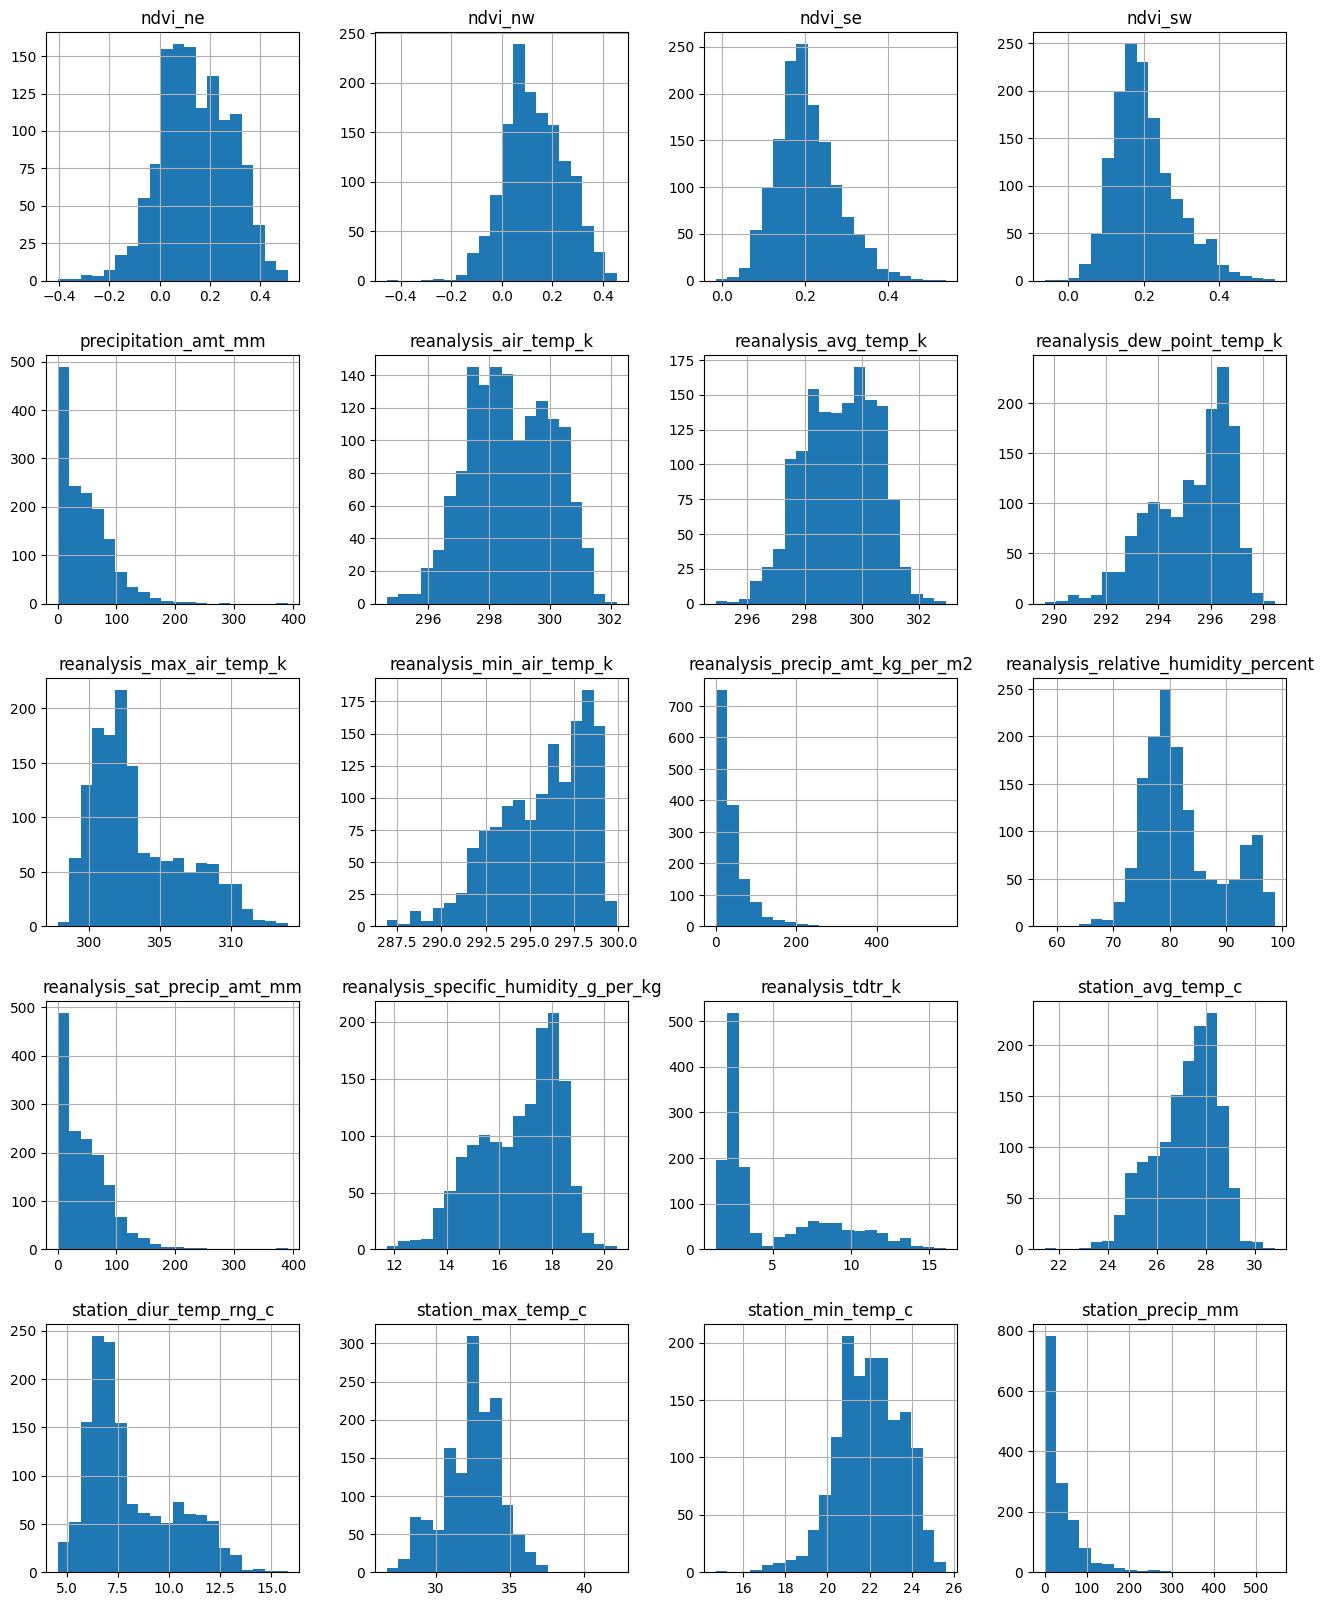

In [15]:
# Histogram sin las primeras 4 columnas
(df_features[df_features.columns[4:]]).hist(figsize=(16,20), bins=20)

In [16]:
# correlacion de las variables en "df_features"
(df_features[df_features.columns[4:]]).corr()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
ndvi_ne,1.000000,0.850902,0.614380,0.669504,0.205736,-0.340976,-0.037682,0.056077,0.634330,-0.623116,0.199411,0.457985,0.205736,0.094852,0.673935,0.186227,0.658129,0.491922,-0.315696,0.242263
ndvi_nw,0.850902,1.000000,0.555809,0.651938,0.193563,-0.317862,-0.030974,0.063289,0.606775,-0.588806,0.190989,0.449152,0.193563,0.100626,0.645596,0.203975,0.649483,0.490122,-0.304206,0.221314
ndvi_se,0.614380,0.555809,1.000000,0.820924,0.074633,-0.157447,0.051348,0.002810,0.468054,-0.407931,0.034792,0.215606,0.074633,0.028795,0.486047,0.089242,0.449599,0.290691,-0.251621,0.131326
ndvi_sw,0.669504,0.651938,0.820924,1.000000,0.124047,-0.227824,0.022533,0.020746,0.546460,-0.494284,0.101652,0.311759,0.124047,0.053437,0.569554,0.121060,0.545899,0.377393,-0.294684,0.158345
precipitation_amt_mm,0.205736,0.193563,0.074633,0.124047,1.000000,-0.017229,0.106384,0.434722,0.282721,-0.119691,0.481159,0.499984,1.000000,0.451202,0.201427,0.225408,0.193358,0.296215,0.076680,0.486637
reanalysis_air_temp_k,-0.340976,-0.317862,-0.157447,-0.227824,-0.017229,1.000000,0.901777,0.529771,-0.001211,0.736765,-0.128219,-0.402338,-0.017229,0.508380,-0.280375,0.619974,-0.261457,0.227768,0.719612,-0.173851
reanalysis_avg_temp_k,-0.037682,-0.030974,0.051348,0.022533,0.106384,0.901777,1.000000,0.614268,0.398224,0.436689,-0.031728,-0.168371,0.106384,0.612484,0.124200,0.751330,0.107581,0.512220,0.579864,-0.048052
reanalysis_dew_point_temp_k,0.056077,0.063289,0.002810,0.020746,0.434722,0.529771,0.614268,1.000000,0.257380,0.361781,0.432970,0.553766,0.434722,0.997051,-0.033512,0.743506,0.037151,0.492319,0.651535,0.241335
reanalysis_max_air_temp_k,0.634330,0.606775,0.468054,0.546460,0.282721,-0.001211,0.398224,0.257380,1.000000,-0.600850,0.192261,0.400093,0.282721,0.300278,0.918578,0.469668,0.834263,0.763446,-0.193709,0.251177
reanalysis_min_air_temp_k,-0.623116,-0.588806,-0.407931,-0.494284,-0.119691,0.736765,0.436689,0.361781,-0.600850,1.000000,-0.105815,-0.410714,-0.119691,0.318592,-0.815511,0.216543,-0.715676,-0.271495,0.720701,-0.237142


## Data Wrangling

<Axes: >

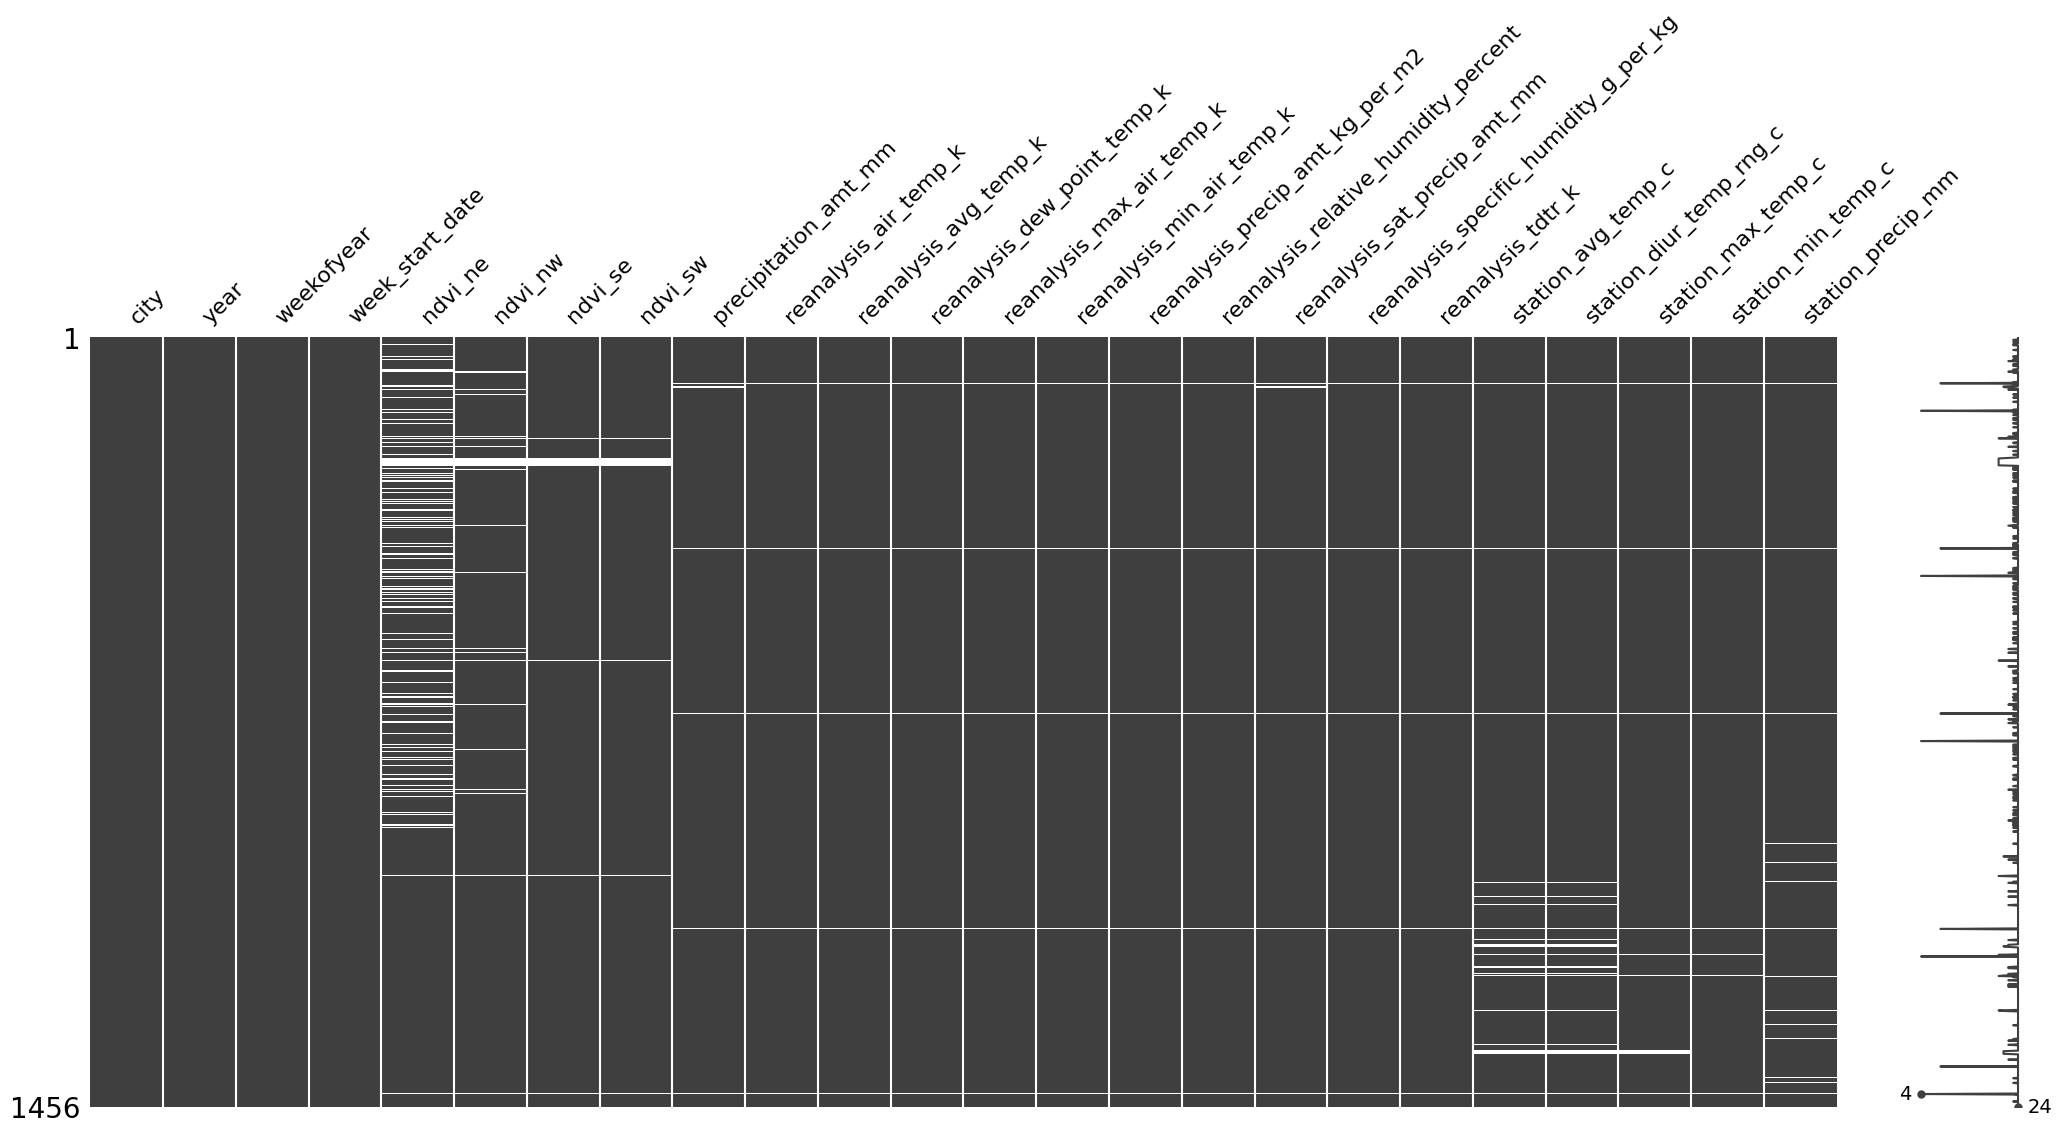

In [17]:
#La función matrix de Missingno permite ver de una forma visual dónde se encuentran los valores nulos en un conjunto de datos.
import missingno as msno
msno.matrix(df_features)

In [18]:
# reemplazamos los nulos por la media
df_features.fillna(df_features.mean(), inplace=True)

<ipython-input-18-3c3f639b5a9e>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_features.fillna(df_features.mean(), inplace=True)


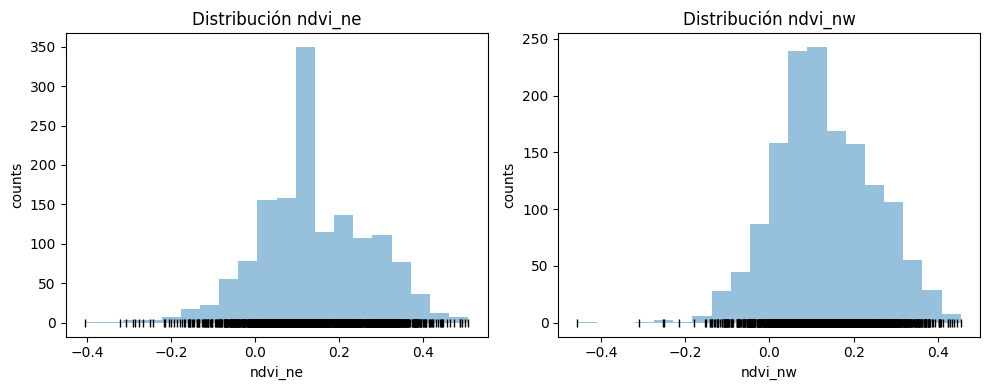

In [21]:
#verficando normalidad de las variables testimoniales
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=df_features.ndvi_ne, bins=20, color="#3182bd", alpha=0.5)
axs[0].plot(df_features.ndvi_ne, np.full_like(df_features.ndvi_ne, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución ndvi_ne')
axs[0].set_xlabel('ndvi_ne')
axs[0].set_ylabel('counts')

axs[1].hist(x=df_features.ndvi_nw, bins=20, color="#3182bd", alpha=0.5)
axs[1].plot(df_features.ndvi_nw, np.full_like(df_features.ndvi_nw, -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución ndvi_nw')
axs[1].set_xlabel('ndvi_nw')
axs[1].set_ylabel('counts')


plt.tight_layout();

In [23]:
#uniremos los dataset de "features" (caracteristicas) con "label" (casos)

# dataset total de casos
df_label_tc = df_label.total_cases

# dataset unificado con cantidad de casos
data_f = pd.concat([df_features, df_label_tc], axis=1)

In [24]:
# cambiando algunos otros tipos de datos
data_f['year']                                  = pd.to_numeric(data_f['year']);
data_f['weekofyear']                            = pd.to_numeric(data_f['weekofyear']);
data_f['week_start_date']                       = pd.to_datetime(data_f['week_start_date']);

## Analisis de Datos

In [25]:
# ANALISIS UNIVARIADO

# Cantidad de datos por ciudad
data_f.city.value_counts()

San Juan, PR    936
Iquito, PE      520
Name: city, dtype: int64

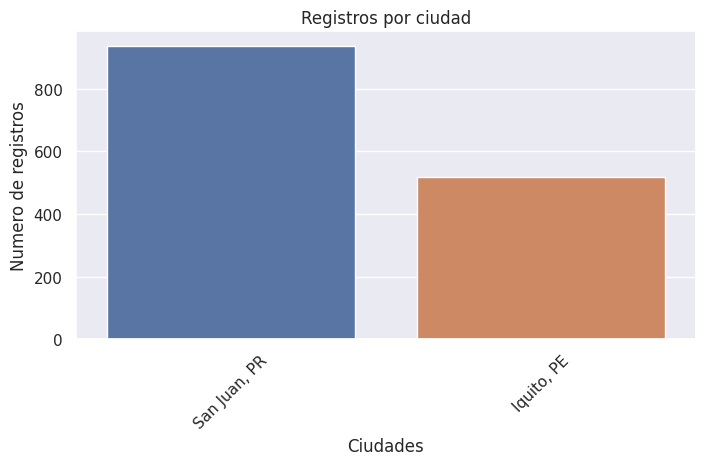

In [26]:
# Total de regsistros por ciudad
plt.figure(figsize=(8,4))
sns.set_theme(style="darkgrid")
sns.countplot(data=data_f, x='city')

plt.title('Registros por ciudad')
plt.ylabel('Numero de registros')
plt.xlabel('Ciudades')
plt.xticks(rotation = 45)
plt.show();

<Axes: xlabel='year', ylabel='total_cases'>

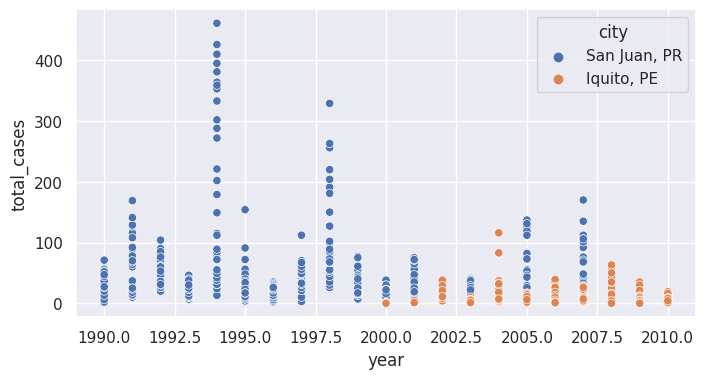

In [27]:
# total de casos por año
plt.figure(figsize=(8,4))
sns.scatterplot(x=data_f.year, y=data_f['total_cases'], hue=data_f['city'])

In [28]:
# Analisis de la Variables; todas
# genero multiples graficos para las variables
columnas = ['year', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases']

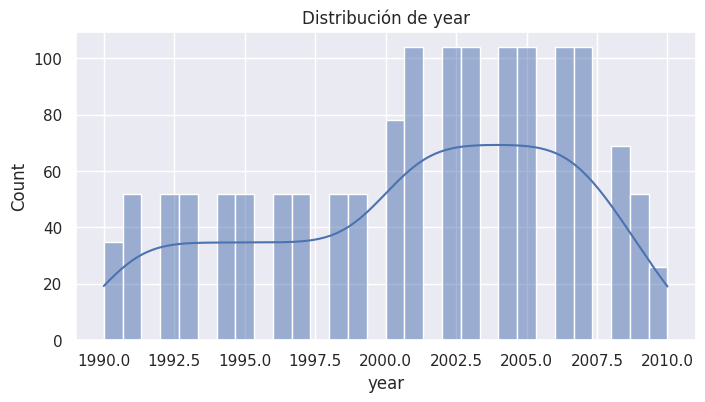

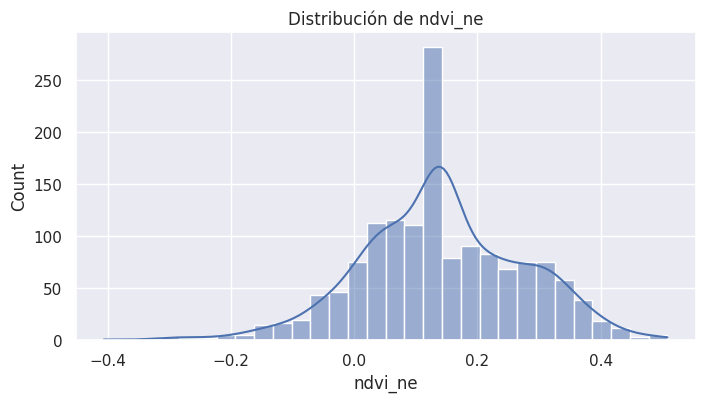

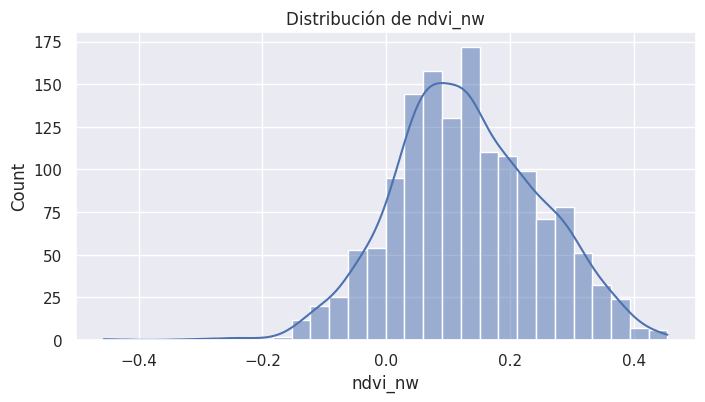

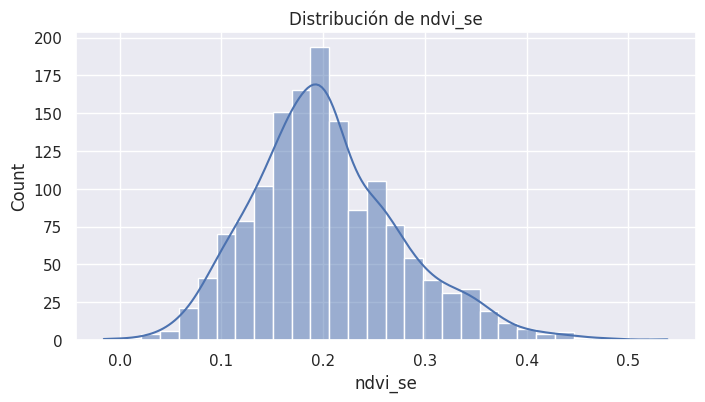

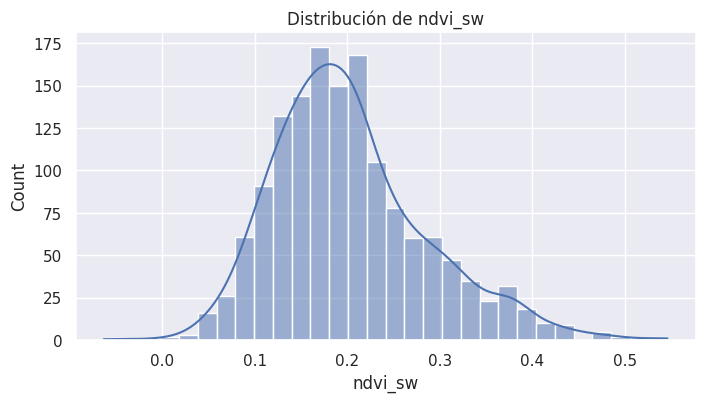

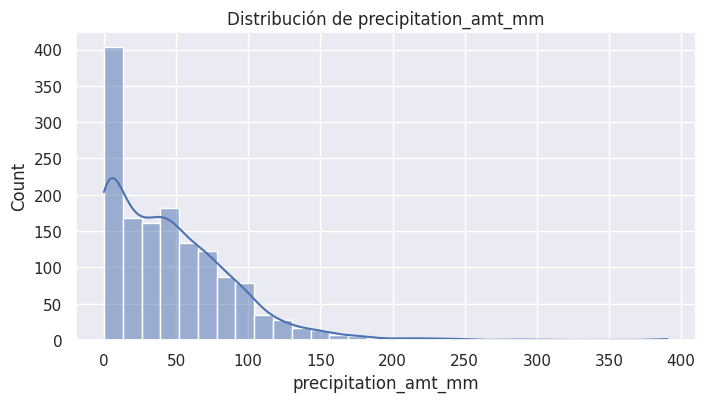

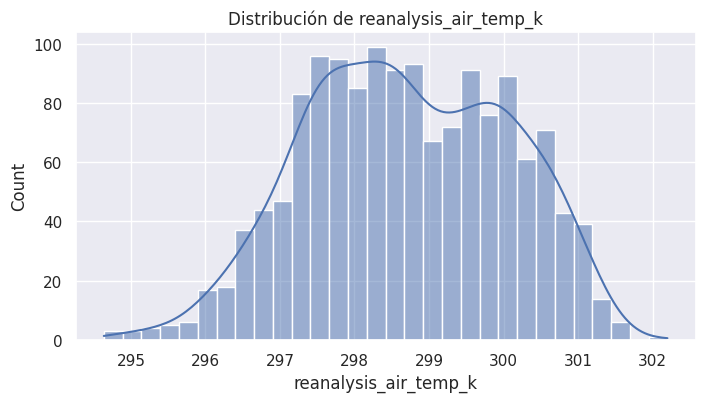

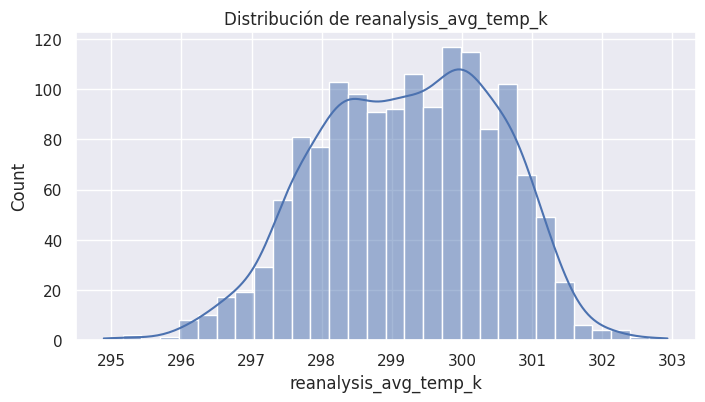

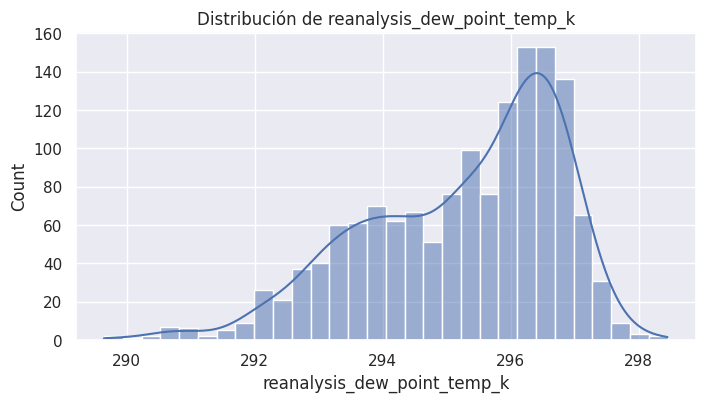

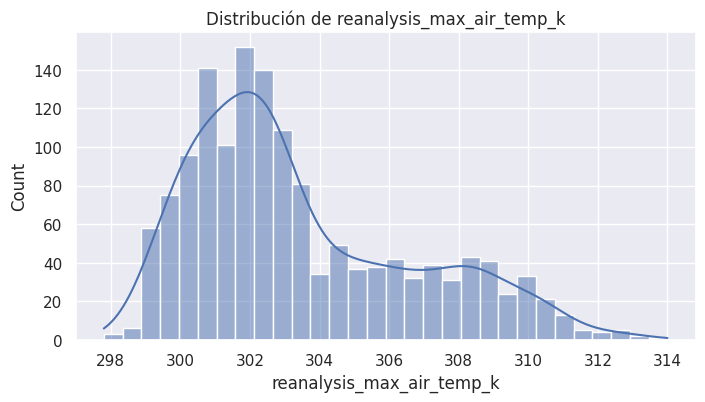

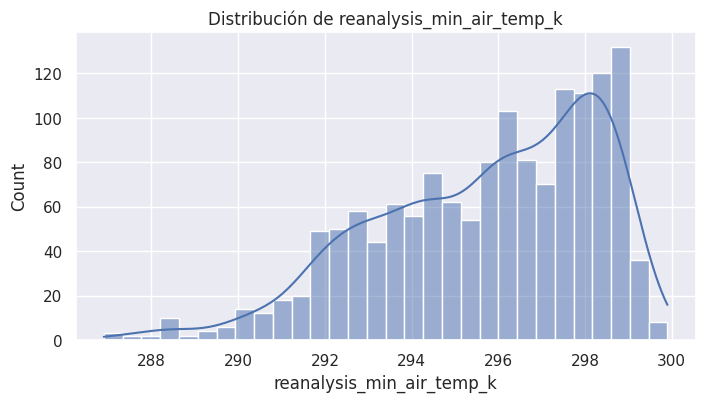

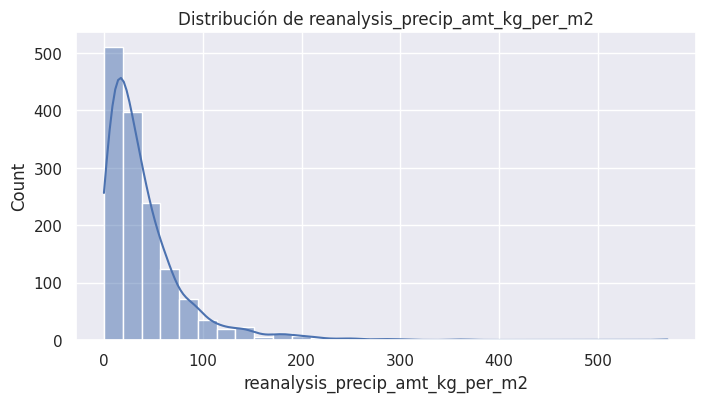

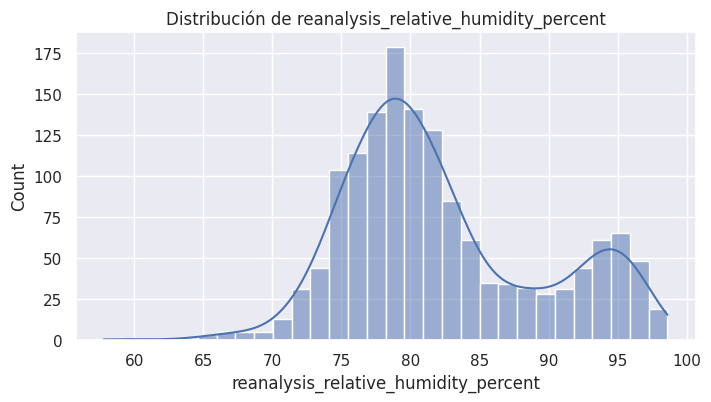

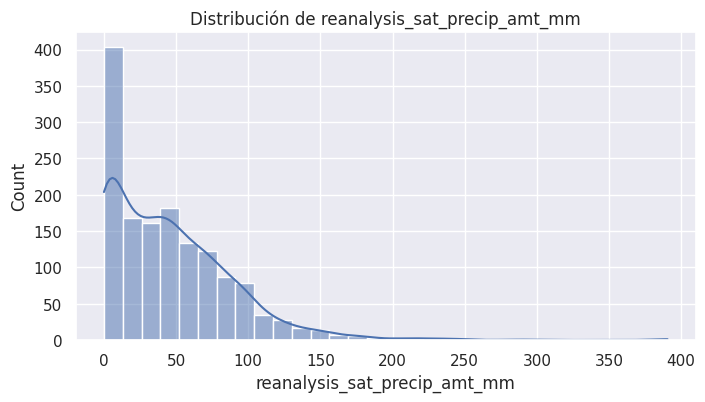

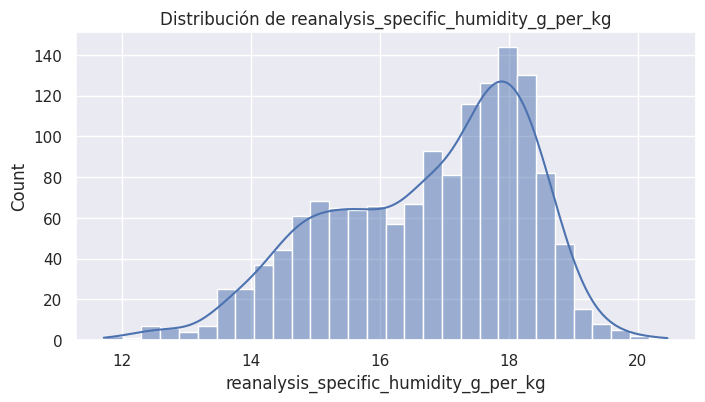

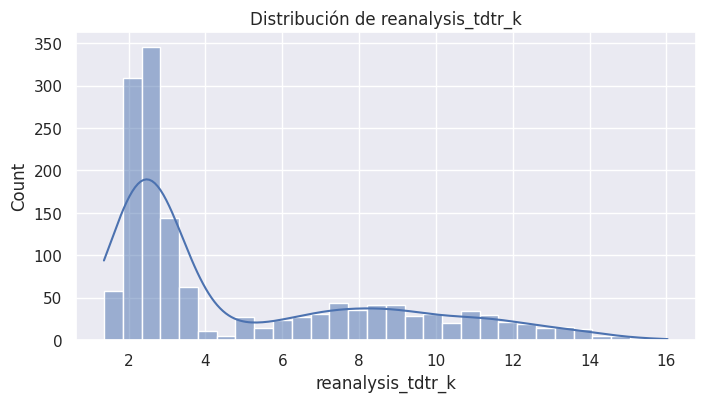

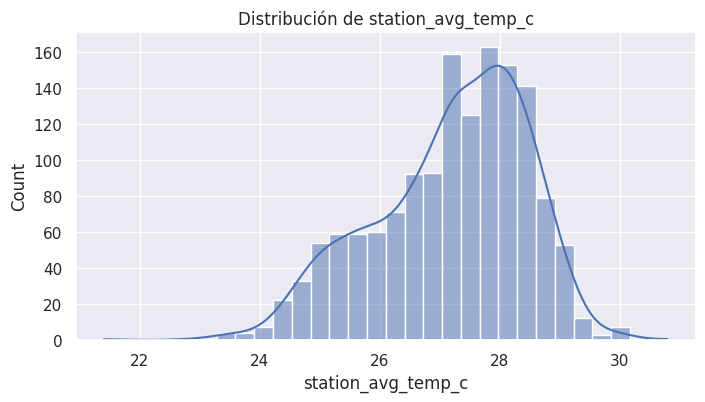

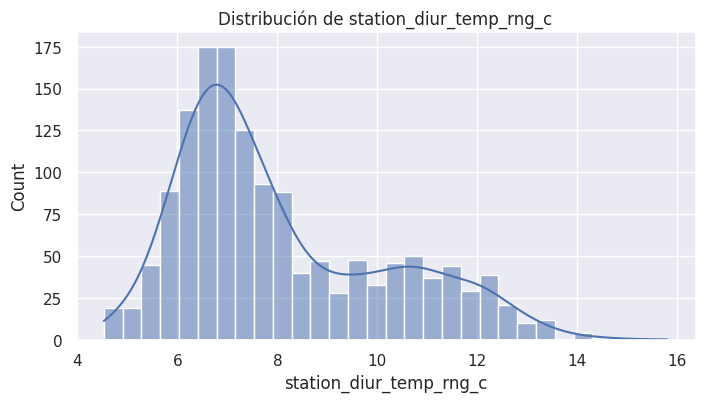

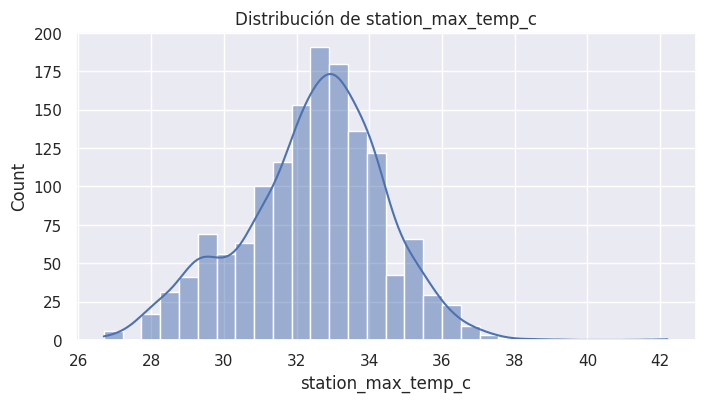

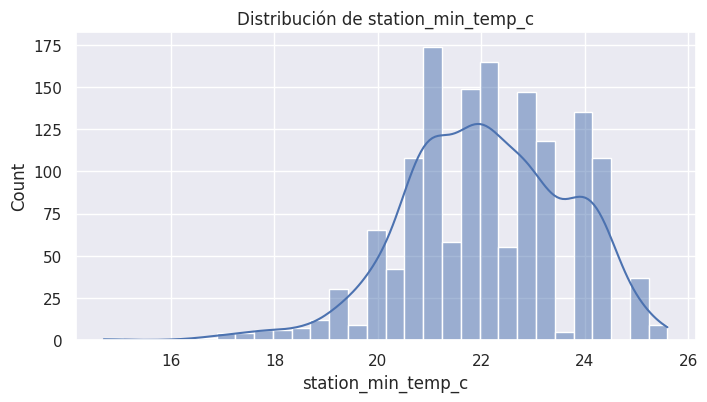

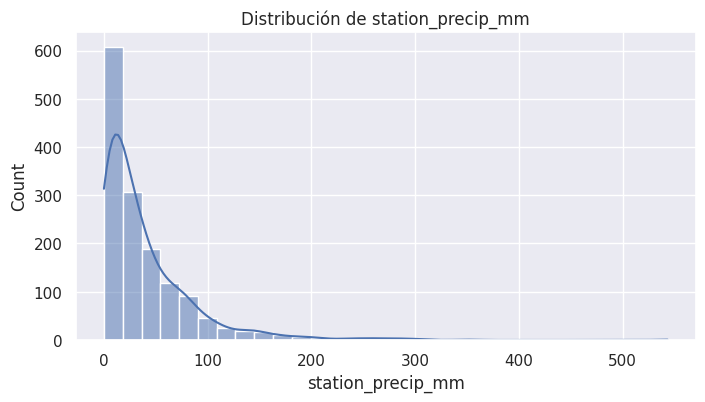

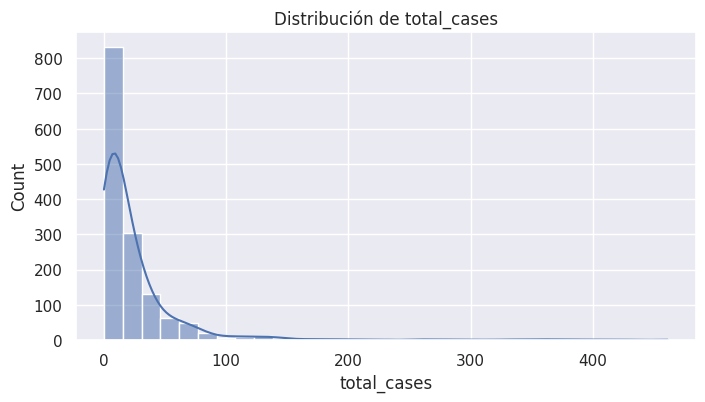

In [29]:
for columna in columnas:
    plt.figure(figsize=(8,4))

    if data_f[columna].dtype in ['int64', 'float64']:  # Datos numéricos
        sns.histplot(data_f[columna], bins=30, kde=True)
    else:  # Datos categóricos
        sns.countplot(data=data_f, x=columna)

    plt.title(f'Distribución de {columna}')
    plt.show()

<Figure size 800x400 with 0 Axes>

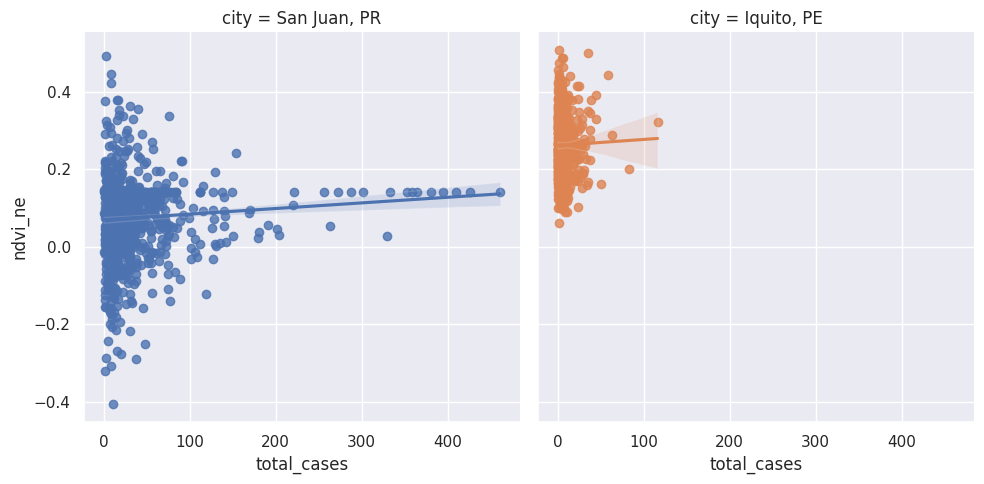

In [30]:
# ANALISIS BIVARIADO

plt.figure(figsize=(8,4))
sns.lmplot(data=data_f, x='total_cases', y='ndvi_ne', col='city', hue='city')

<Figure size 800x400 with 0 Axes>

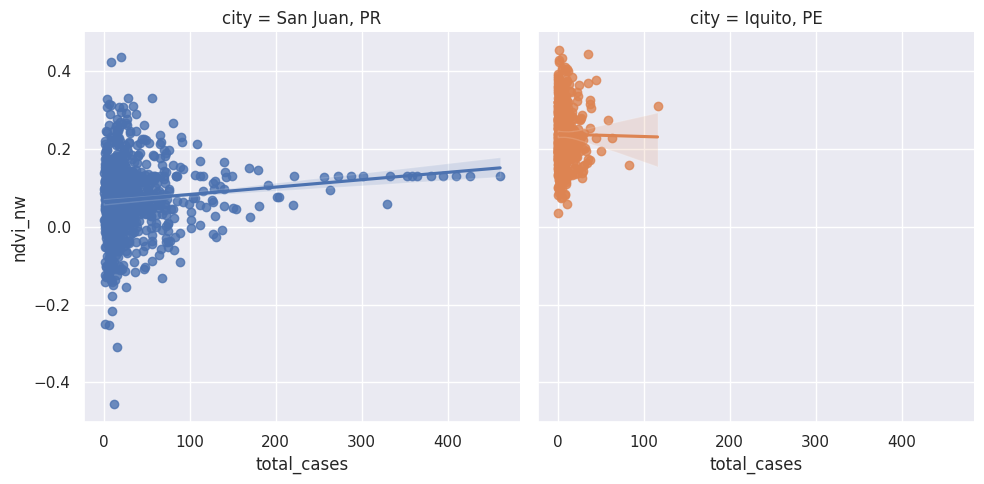

In [31]:
plt.figure(figsize=(8,4))
sns.lmplot(data=data_f, x='total_cases', y='ndvi_nw', col='city', hue='city')

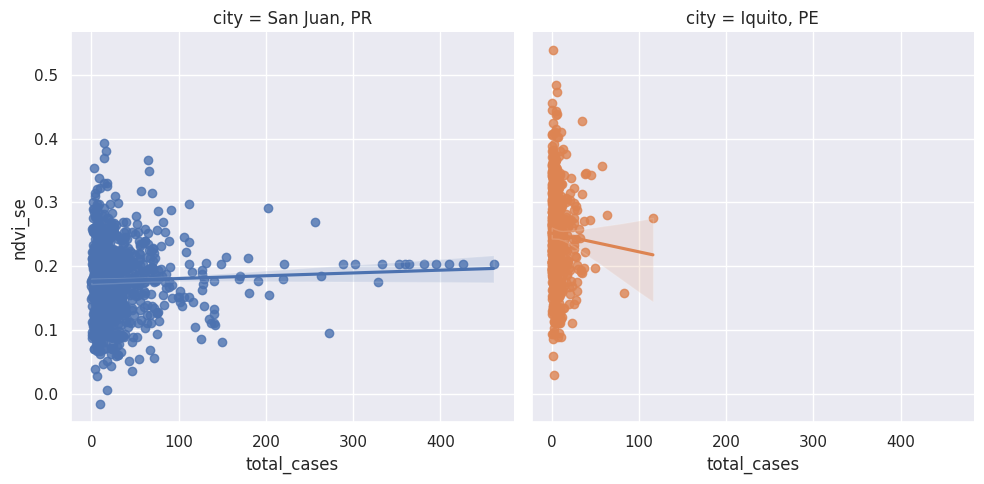

In [32]:
sns.lmplot(data=data_f, x='total_cases', y='ndvi_se', col='city', hue='city')

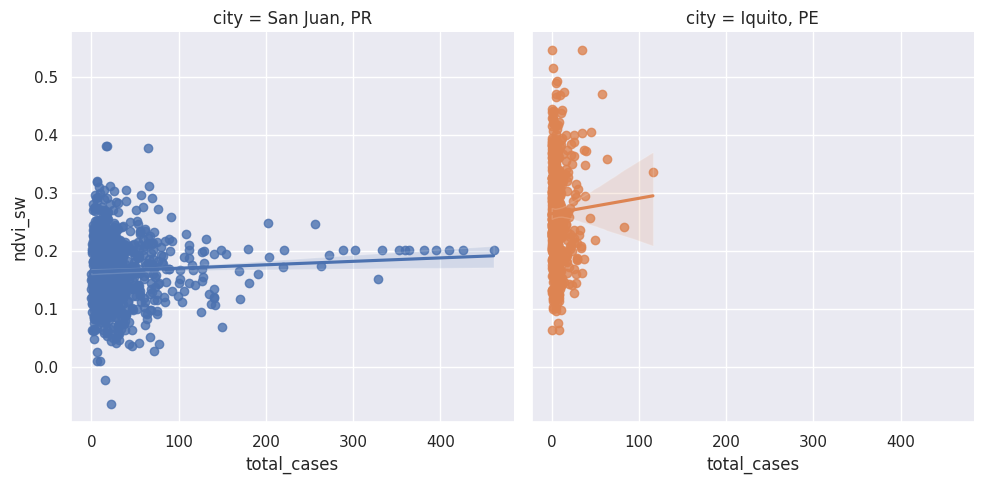

In [33]:
sns.lmplot(data=data_f, x='total_cases', y='ndvi_sw', col='city', hue='city')

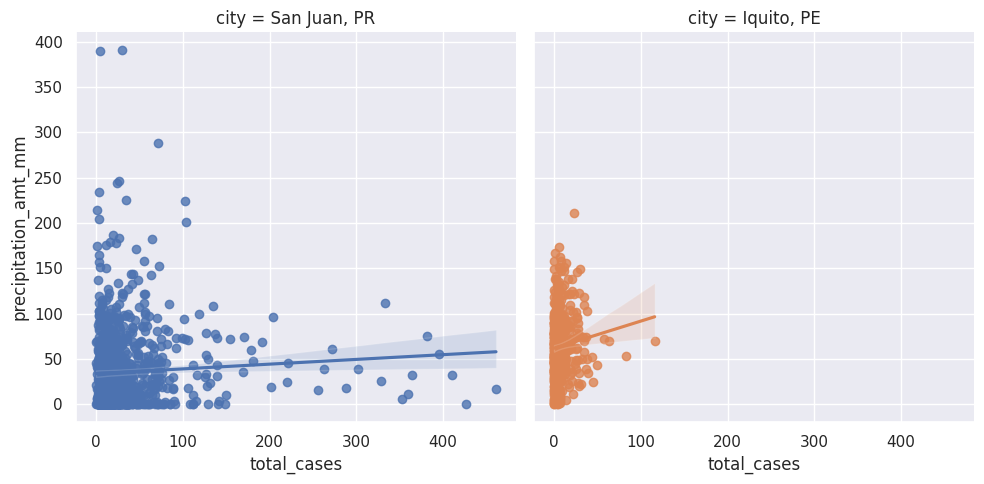

In [34]:
sns.lmplot(data=data_f, x='total_cases', y='precipitation_amt_mm', col='city', hue='city')

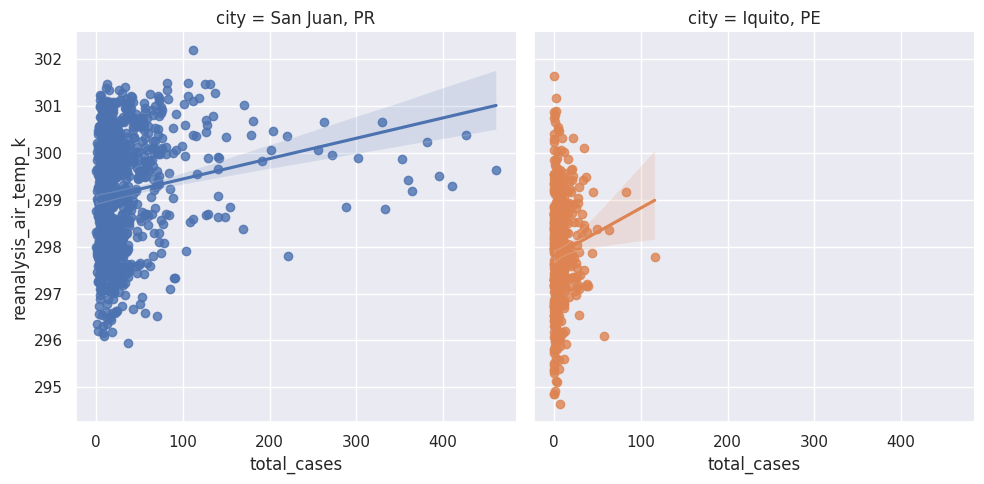

In [35]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_air_temp_k', col='city', hue='city')

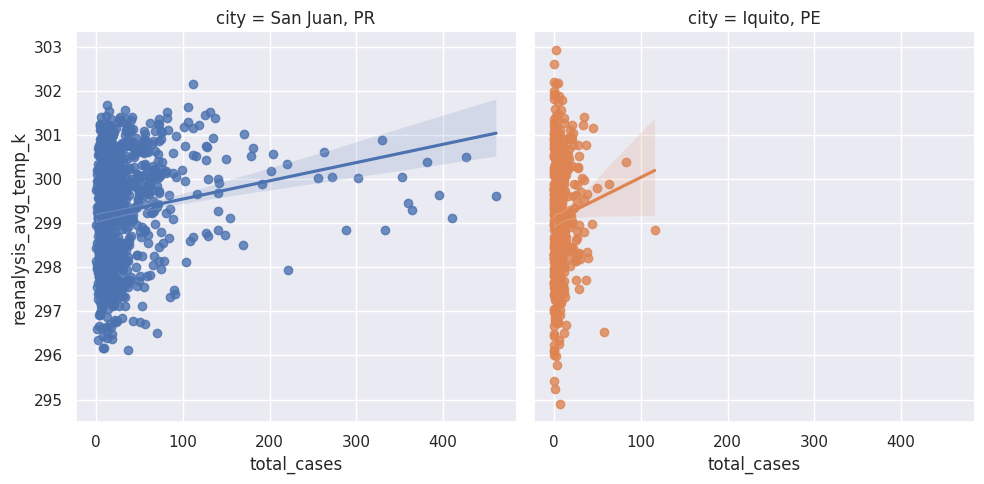

In [36]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_avg_temp_k', col='city', hue='city')

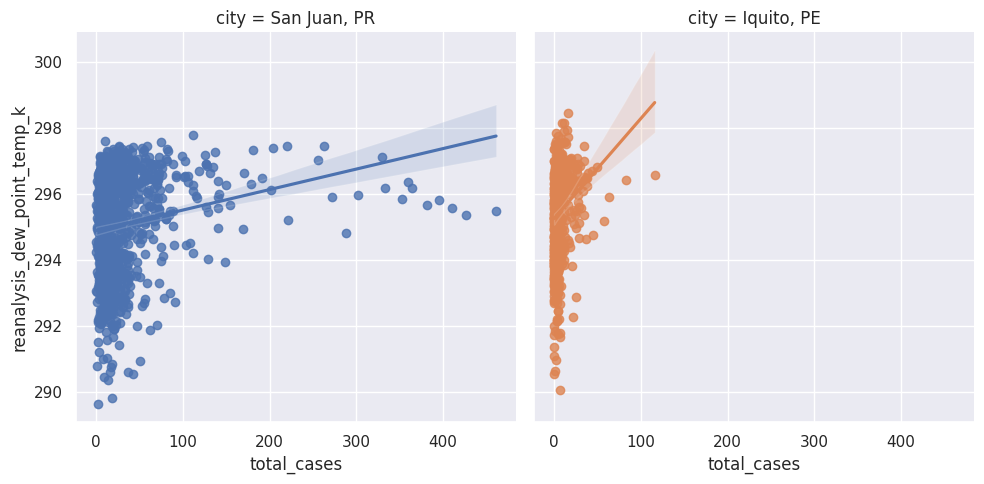

In [37]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_dew_point_temp_k', col='city', hue='city')

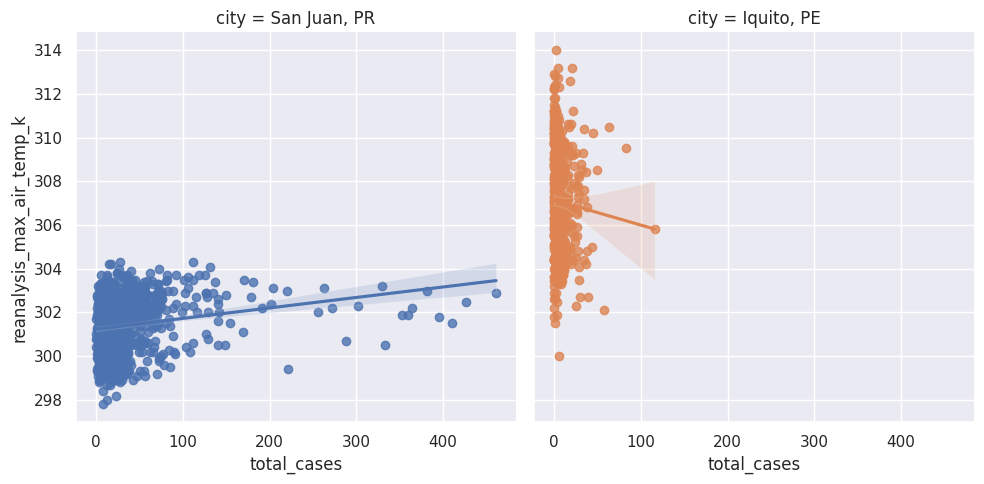

In [38]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_max_air_temp_k', col='city', hue='city')

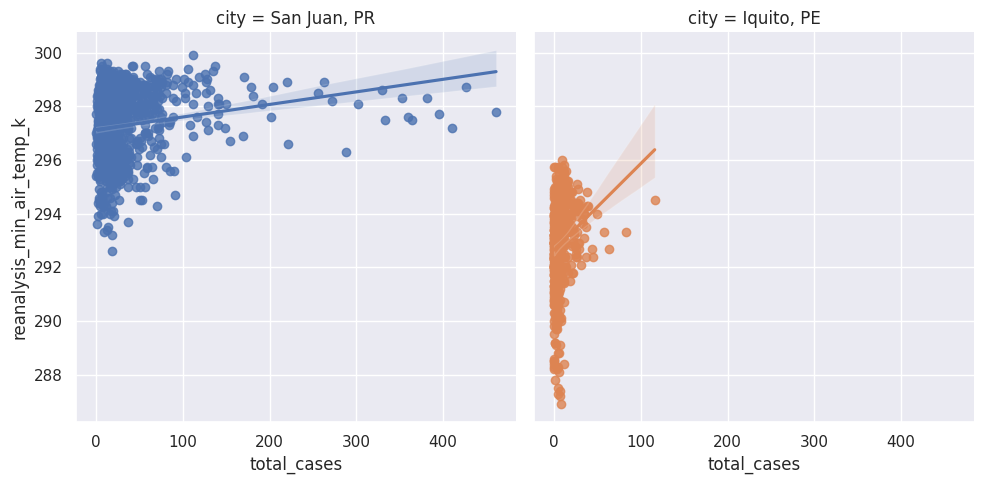

In [39]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_min_air_temp_k', col='city', hue='city')

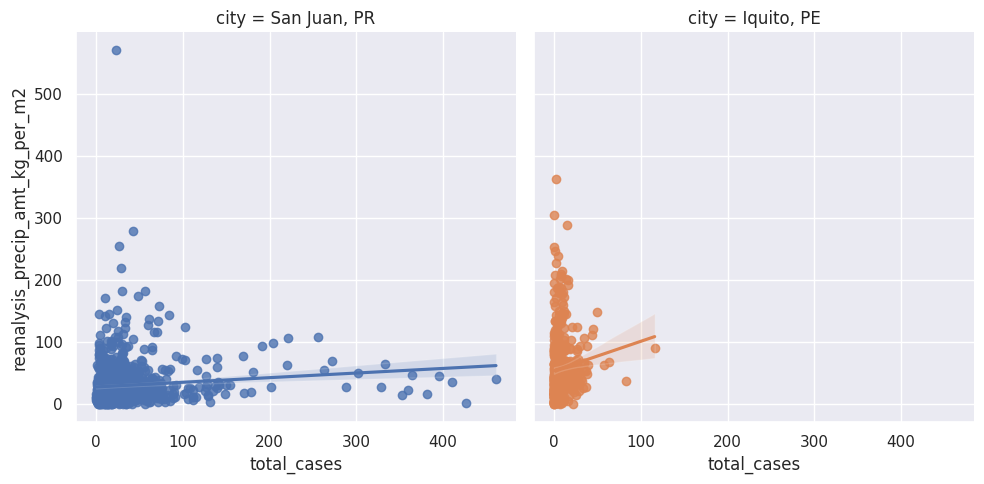

In [40]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_precip_amt_kg_per_m2', col='city', hue='city')

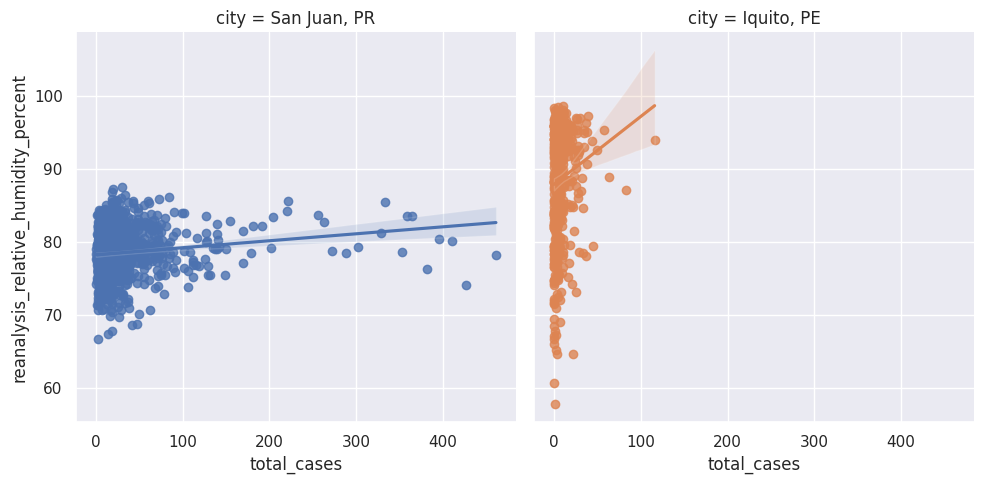

In [41]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_relative_humidity_percent', col='city', hue='city')

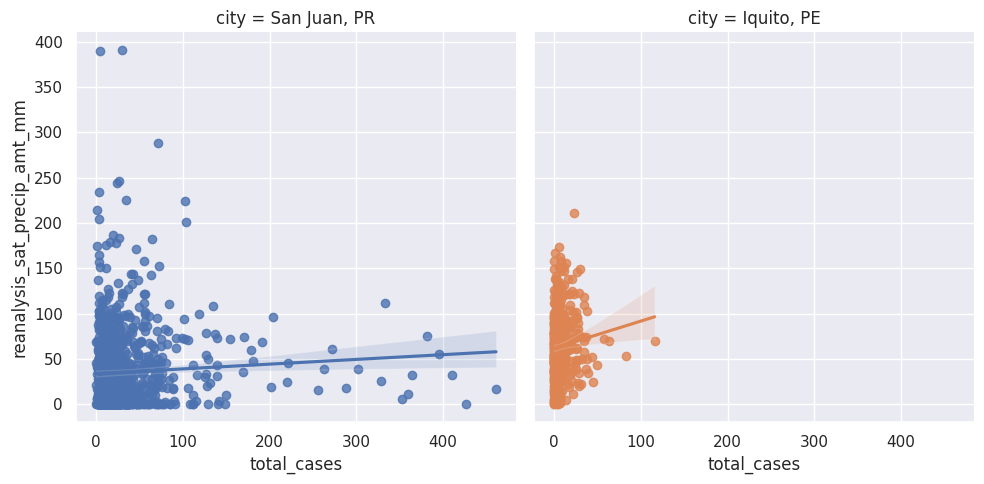

In [42]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_sat_precip_amt_mm', col='city', hue='city')

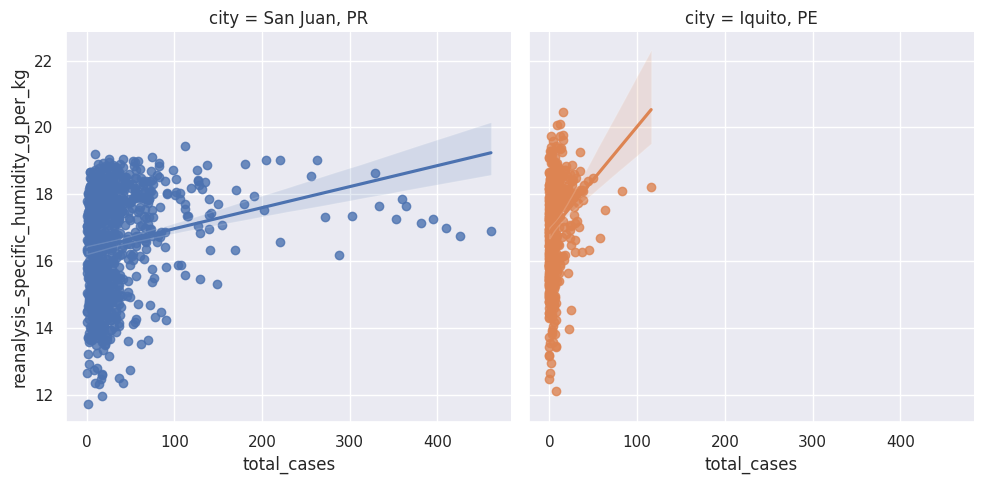

In [43]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_specific_humidity_g_per_kg', col='city', hue='city')

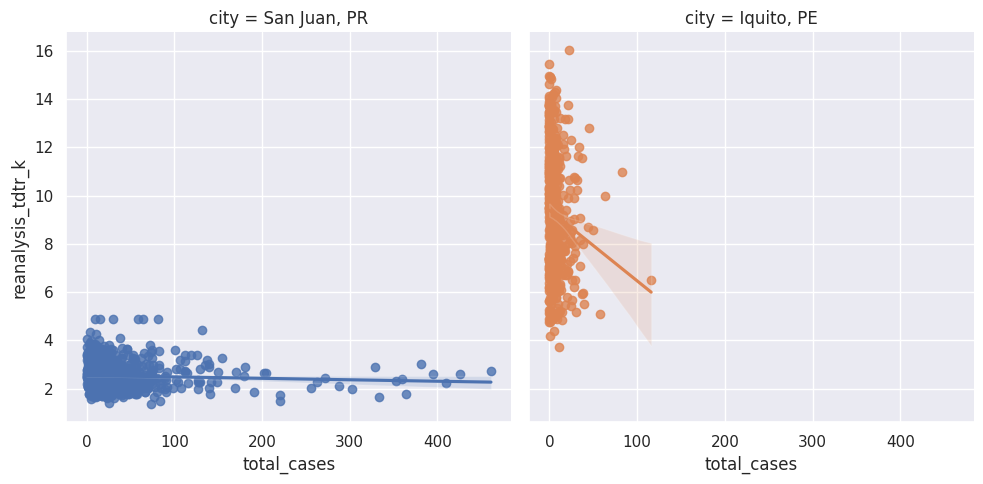

In [44]:
sns.lmplot(data=data_f, x='total_cases', y='reanalysis_tdtr_k', col='city', hue='city')

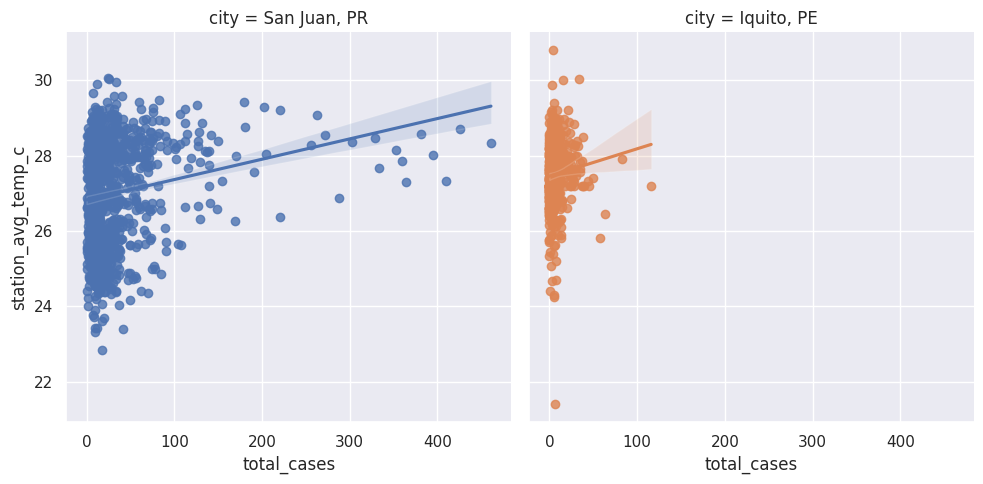

In [45]:
sns.lmplot(data=data_f, x='total_cases', y='station_avg_temp_c', col='city', hue='city')

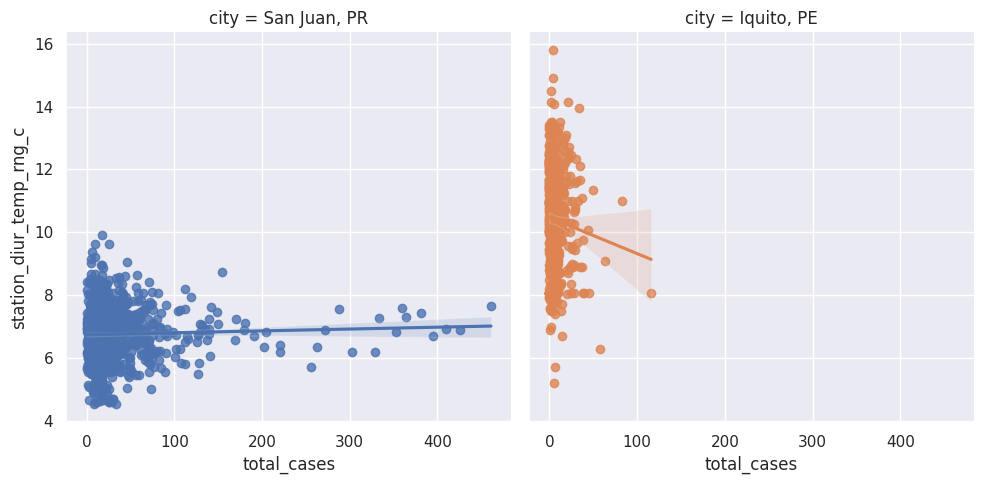

In [46]:
sns.lmplot(data=data_f, x='total_cases', y='station_diur_temp_rng_c', col='city', hue='city')

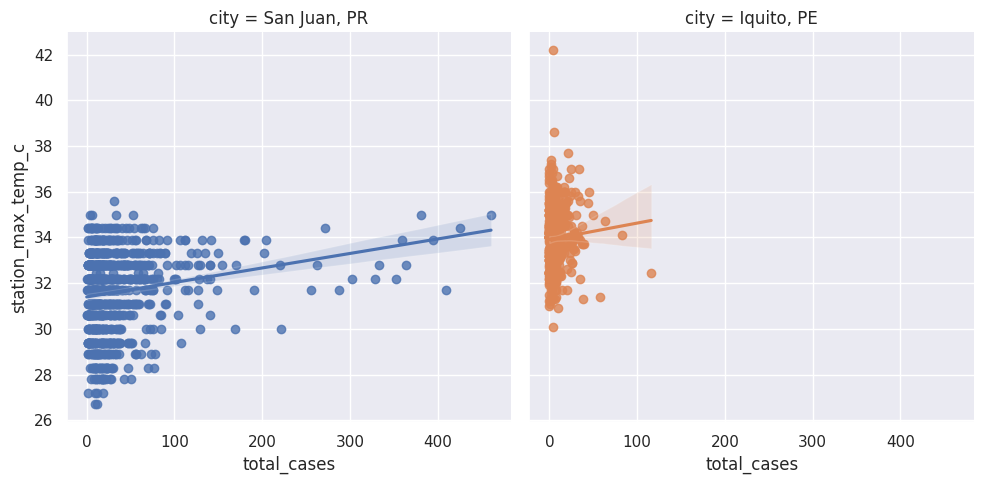

In [47]:
sns.lmplot(data=data_f, x='total_cases', y='station_max_temp_c', col='city', hue='city')

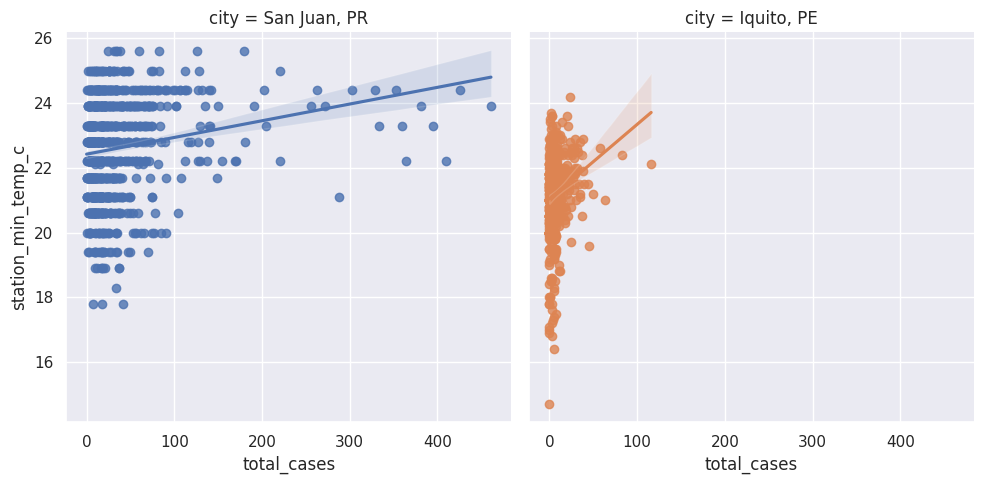

In [48]:
sns.lmplot(data=data_f, x='total_cases', y='station_min_temp_c', col='city', hue='city')

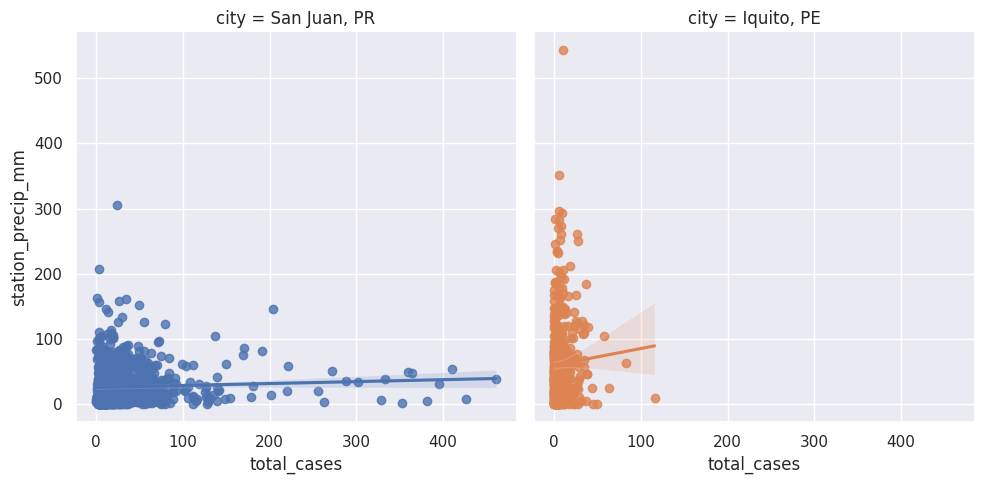

In [49]:
sns.lmplot(data=data_f, x='total_cases', y='station_precip_mm', col='city', hue='city')

In [50]:
# Promedios de Casos por año
años_prom_datos = pd.DataFrame(data_f.groupby(['year']).mean())

<ipython-input-50-e05cd1f11778>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  años_prom_datos = pd.DataFrame(data_f.groupby(['year']).mean())


<Axes: xlabel='year', ylabel='total_cases'>

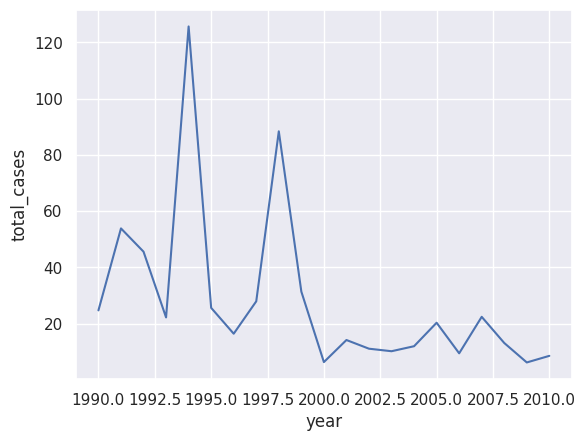

In [51]:
sns.lineplot(data=años_prom_datos, x=años_prom_datos.index, y=años_prom_datos['total_cases'])

In [52]:
# Proemdio de casos por semana
sem_prom_datos = pd.DataFrame(data_f.groupby(['weekofyear']).mean())

<ipython-input-52-5cc2a69c5081>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_prom_datos = pd.DataFrame(data_f.groupby(['weekofyear']).mean())


<Axes: xlabel='weekofyear', ylabel='total_cases'>

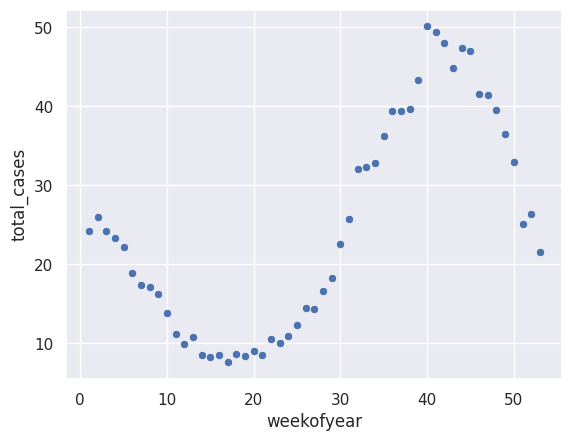

In [53]:
sns.scatterplot(data=sem_prom_datos, x=sem_prom_datos.index, y=sem_prom_datos['total_cases'])

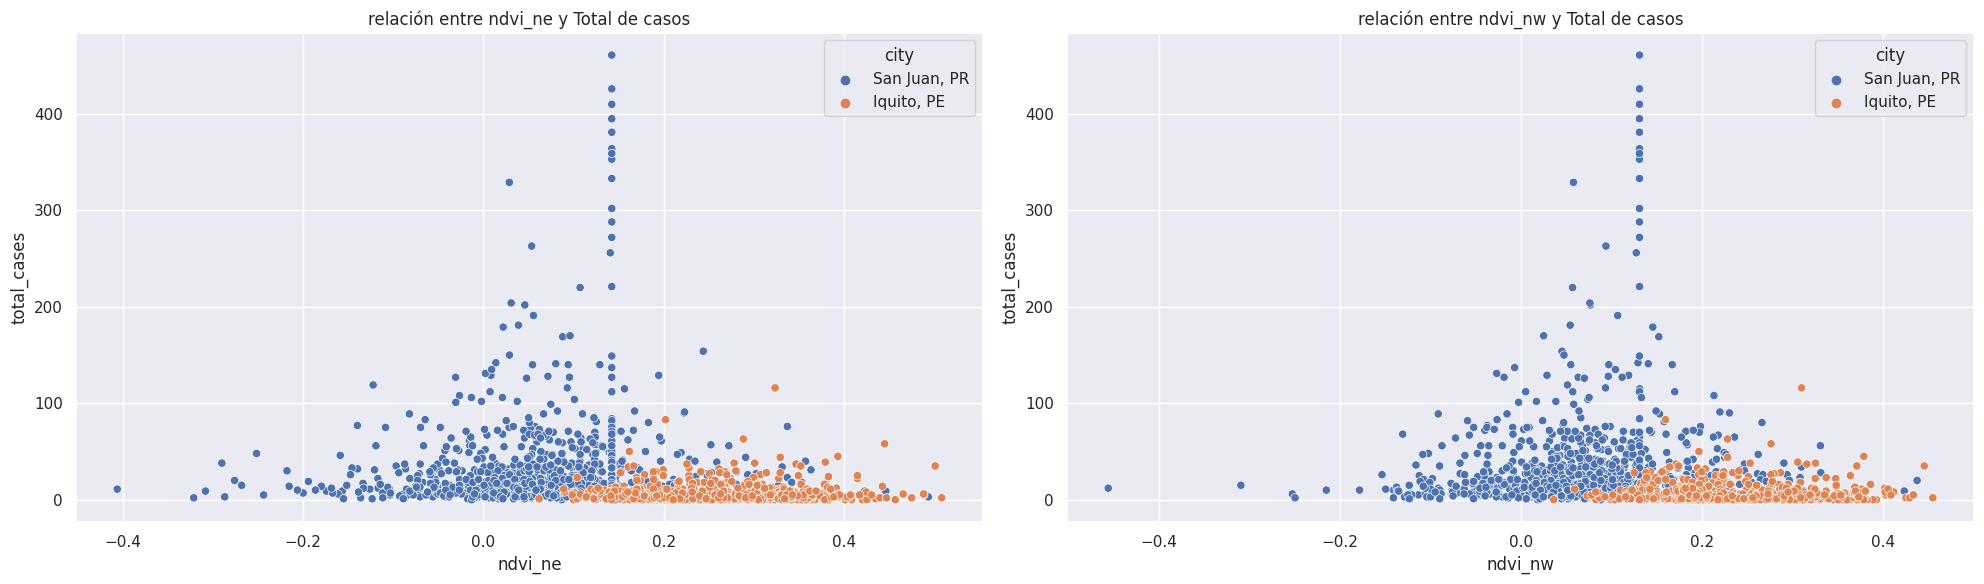

In [54]:
# Total de casos por indice de vegetación
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['ndvi_ne', 'ndvi_nw']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i], hue='city')
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

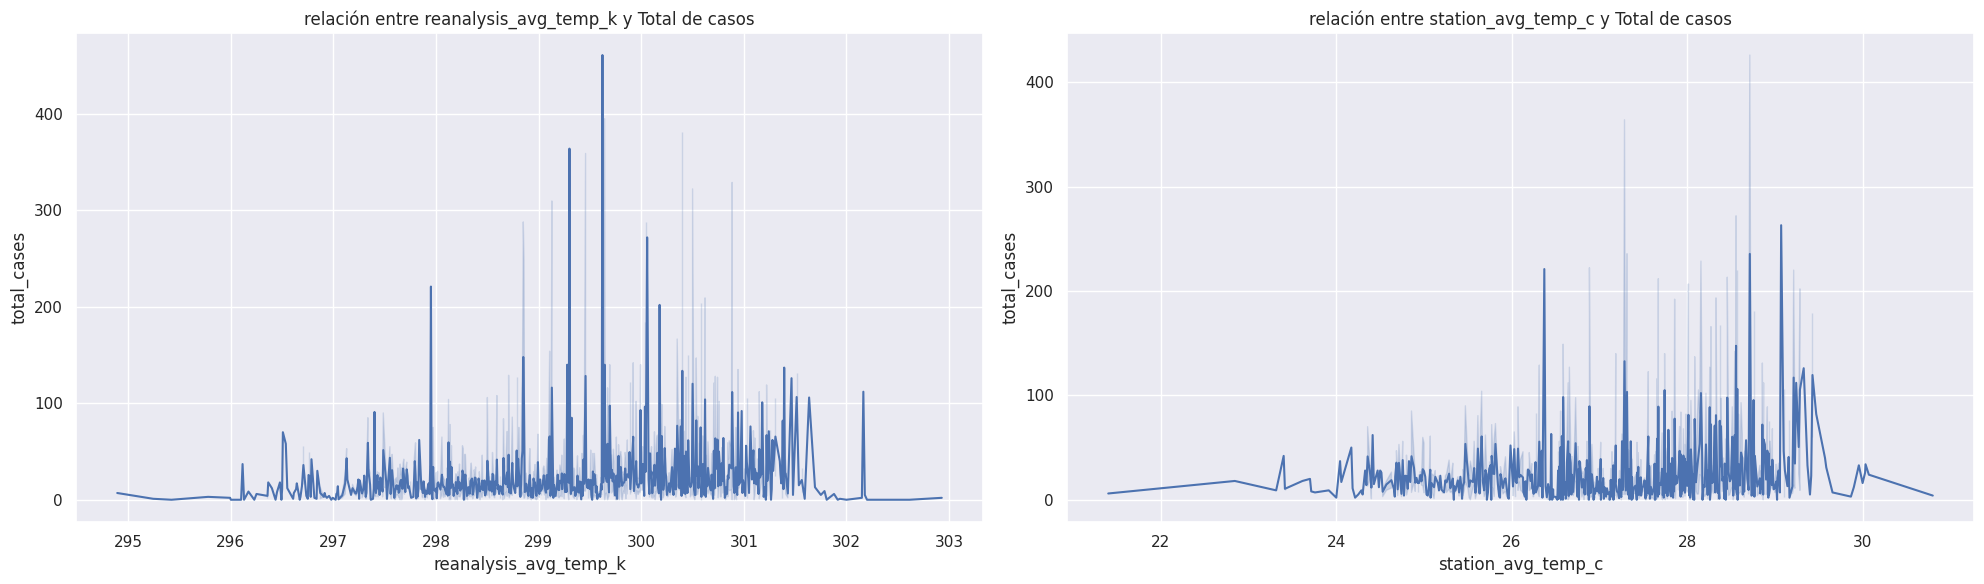

In [55]:
# Total de Casos en relación a las temperaturas promedio
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['reanalysis_avg_temp_k', 'station_avg_temp_c']
for i, col in enumerate(col2):
  sns.lineplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

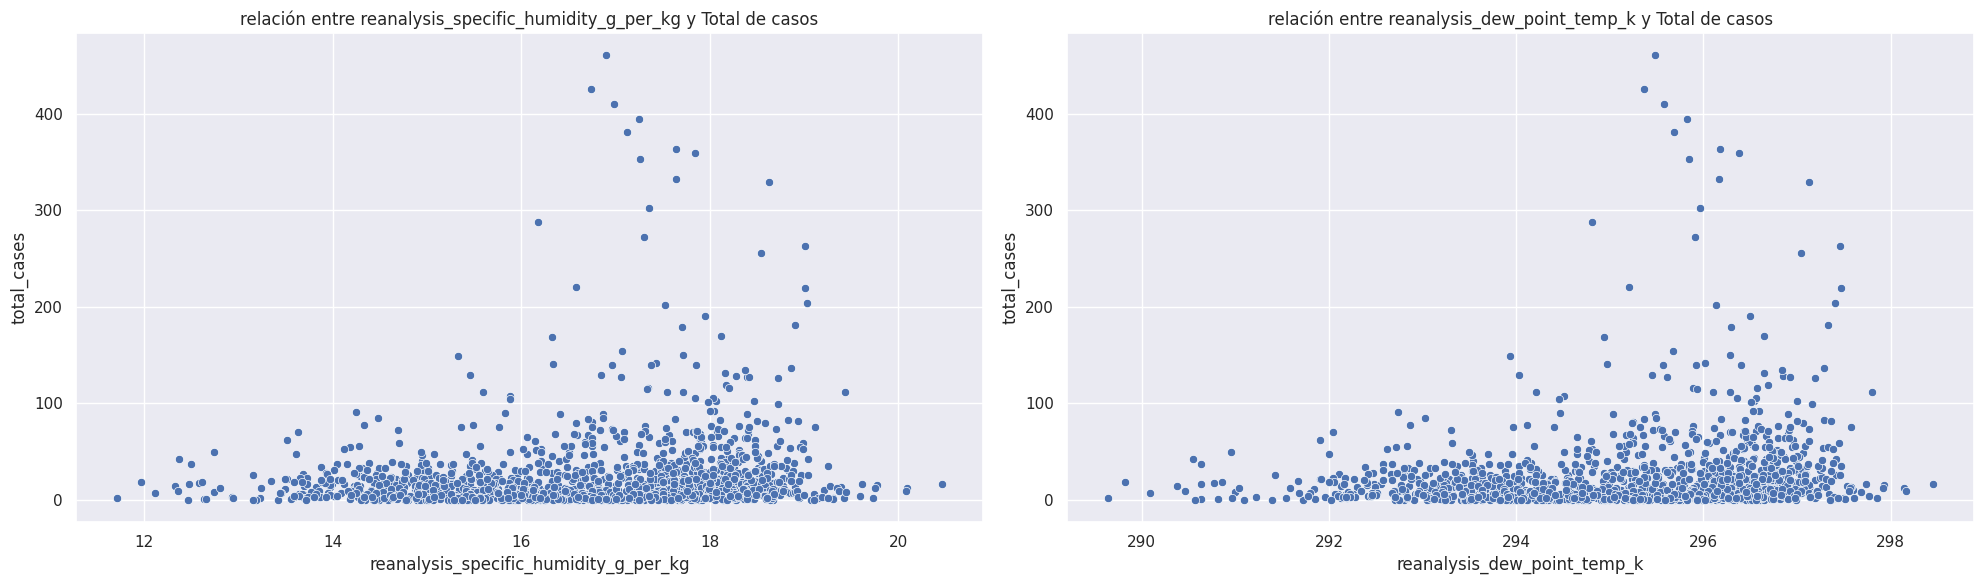

In [56]:
# Total de casos en relación a la humedad
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
col2 = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

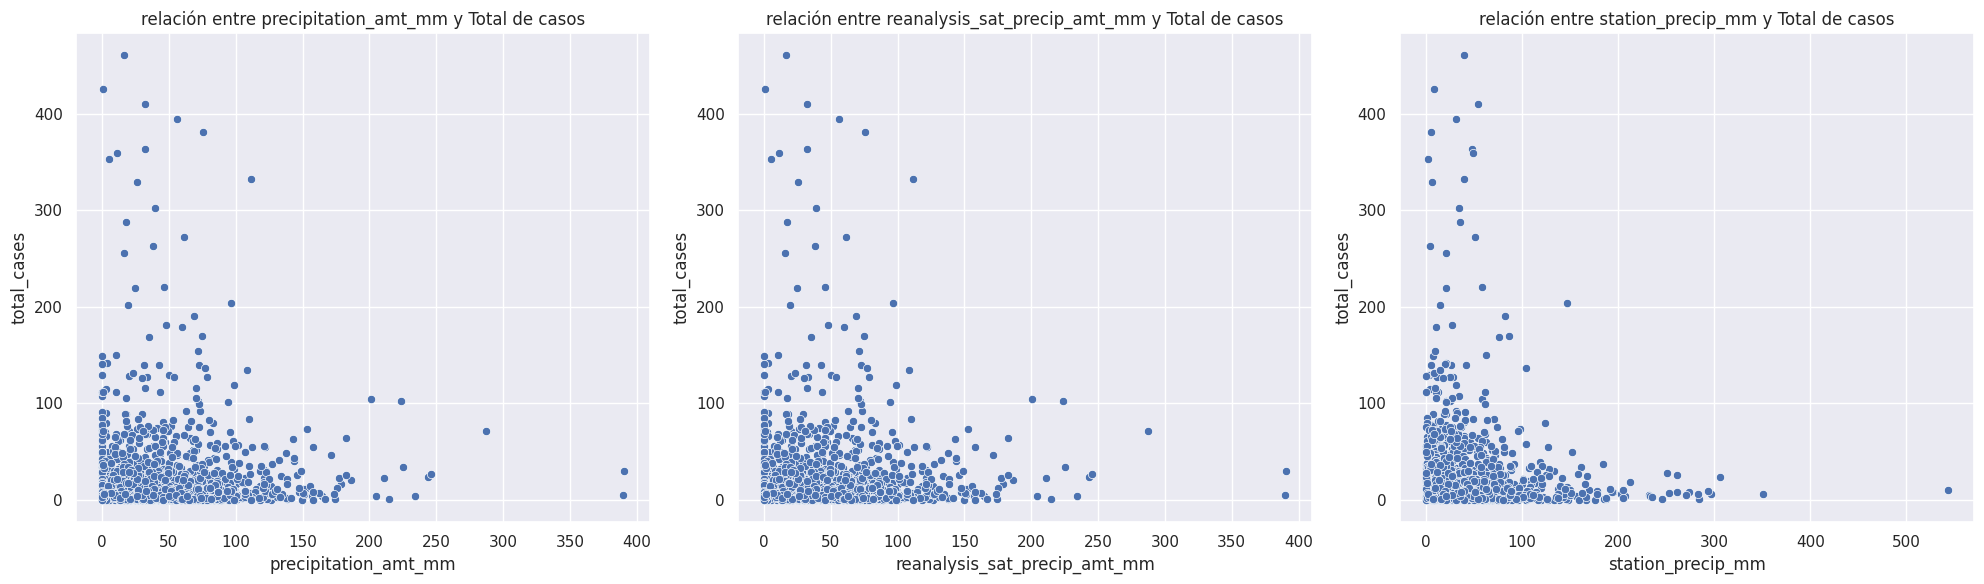

In [57]:
# Total de casos en relacion a las precipataciones
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
col2 = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
for i, col in enumerate(col2):
  sns.scatterplot(data=data_f, x=col, y='total_cases', ax=axes[i])
  axes[i].set_title(f'relación entre {col} y Total de casos')

plt.tight_layout() #ajusta parametros de los subgraficos para verlos mejor
plt.show()

In [ ]:
#######################################
#from sklearn.model_selection import train_test_split

#X = df.drop(columns=['total_cases', 'week_start_date', 'city'])
#y = df['total_cases']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

########################################

In [60]:
# ANALISIS MULTIVARIADO

# Haremos análisis en relación a temperaturas, vegetación y humedad
# genenramos listas de columnas a analizar
temperaturas = ['station_avg_temp_c','station_max_temp_c','station_min_temp_c']
vegetacion = ['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw']
humedad = ['reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent', 'reanalysis_dew_point_temp_k']

In [65]:
#analisis de componetes principales
X = data_f.iloc[:,4:-1] # todas las columnas menos las 4 primeras y la última
X = StandardScaler().fit_transform(X)

In [67]:
# crear el objeto PCA y ajustar datos
pca = PCA(n_components=2)  # Reducir a 2 componentes
principalComponents = pca.fit_transform(X)

In [68]:
# Crear un DataFrame con los componentes principales
principalDf = pd.DataFrame(data=principalComponents, columns=['CP1', 'CP2'])

In [70]:
# cuanta varianza se explica por cada componete
var_explicada = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {var_explicada}')
print(f'Varianza Total explicada: {var_explicada.sum()}')

Varianza explicada por cada componente: [0.34962107 0.26498338]
Varianza Total explicada: 0.6146044511733492


Text(0, 0.5, 'CP2')

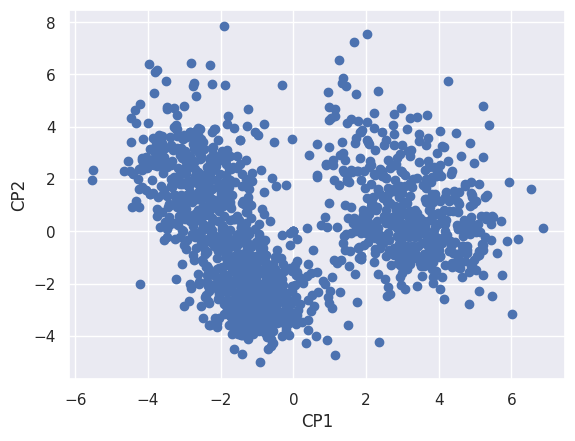

In [74]:
fig, ax = plt.subplots()
ax.scatter(principalDf['CP1'], principalDf['CP2'])
ax.set_xlabel('CP1')
ax.set_ylabel('CP2')

In [ ]:
### MODELOS ML y MVP - 10/10/2023

In [ ]:
data_f.info()

In [121]:
#dataset del modelo por temperatura, vegetación y humedad
X = data_f[temperaturas]
y = data_f['total_cases']

#spliteando los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#reseteando indices
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [113]:
## RANDOM FOREST
modelo_rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=5, min_samples_leaf=3)
#model_rf = RandomForestRegressor()
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=5)

In [114]:
preds_test_rf = modelo_rf.predict(X_test)
mae = mean_absolute_error(y_test, preds_test_rf)
print(f"MAE: {mae}")

MAE: 26.993150684931507


In [ ]:
# Evaluando modelo de RF
print(classification_report(y_test, preds_test_rf))
print(confusion_matrix(y_test, preds_test_rf))

In [125]:
### SVC
modelo_svr = SVC(C=0.1, kernel='rbf',random_state=42)
modelo_svr.fit(X_train, y_train)

SVC(C=0.1, random_state=42)

In [126]:
preds_test_svr = modelo_svr.predict(X_test)
mae = mean_absolute_error(y_test, preds_test_svr)
print(f"MAE: {mae}")

MAE: 30.856164383561644


In [ ]:
# Evaluando modelo de SVR
print(classification_report(y_test, preds_test_svr))
print(confusion_matrix(y_test, preds_test_svr))

## Necesito comprender mejor los Modelos a aplicar
* escalar las características para que todas estén en la misma escala
* ajustar los hiperparámetros de los modelos para mejorar el rendimiento.

In [ ]:
# Aplicando transformación de features numéricas
#num_features =
#ss = StandardScaler()
#ss.fit(X_train[num_features])
#X_train_num = ss.transform(X_train[num_features])
#X_train_num = pd.DataFrame(X_train_num, columns=ss.get_feature_names_out())

In [ ]:
# Regresion Logistica
#model_rl = LogisticRegression()
#model_rl.fit(X_train, y_train)

#predic_rl = model_rl.predict(X_test)
#mae = mean_absolute_error(y_test, predic_rl)
#print(f"MAE: {mae}")